<a href="https://colab.research.google.com/github/scottthomaswx/taf-verification/blob/main/TAF_Verification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [329]:
# @title
%%capture
!pip install pydantic
!pip install datetime
!pip install pytz
!pip install pandas
!pip install matplotlib
!pip install numpy
import pytz
import pydantic
import os
import sys
import requests
from datetime import timedelta
import datetime as datetime
from datetime import datetime
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [476]:
year = '2025' #@param {type:"string"}
month = '08' #@param {type:"string"}
day = '01' #@param {type:"string"}
hour = '00' #@param ["00", "06", "12", "18"] {type:"string"}
airport = 'KGRR' #@param {type:"string"}

timezone = 'UTC'
tz = pytz.timezone(timezone)
start = tz.localize(datetime(int(year),int(month),int(day),int(hour)))

Extended_Taf_List = ['KAUS', 'KATL', 'KBDL', 'KBOS', 'KBWI', 'KBZN', 'KCLE', 'KCLT', 'KCVG', 'KDCA', 'KDEN', 'KDFW', 'KDTW', 'KEWR', 'KFLL', 'KIAD', 'KIAH', 'KIND',
                     'KJFK', 'KLAS', 'KLAX', 'KLGA', 'KMCO', 'KMDW', 'KMEM', 'KMIA', 'KMKE', 'KMSP', 'KMSY', 'KOAK', 'KONT', 'KORD', 'KPHL', 'KPHX', 'KPIT', 'KSAN',
                     'KSDF', 'KSEA', 'KSFO', 'KSLC', 'KSTL', 'KSWF', 'KSAT', 'KTPA', 'KTEB', 'PANC', 'PAFA', 'PGUM', 'PHNL']

if airport in Extended_Taf_List:
  end_time = start + timedelta(hours=30)
  end_year = end_time.strftime('%Y')
  end_month = end_time.strftime('%m')
  end_day = end_time.strftime('%d')
  end_hour = end_time.strftime('%H')
else:
  end_time = start + timedelta(hours=24)
  end_year = end_time.strftime('%Y')
  end_month = end_time.strftime('%m')
  end_day = end_time.strftime('%d')
  end_hour = end_time.strftime('%H')

if hour == '00':
    start_time = start - timedelta(hours=1)
    start_hour = start_time.strftime('%H')
    start_day = start_time.strftime('%d')
    start_month = start_time.strftime('%m')
    start_year = start_time.strftime('%Y')

else:
  start_day = start.strftime('%d')
  start_time = start - timedelta(hours=1)
  start_hour = start_time.strftime('%H')
  start_month = start_time.strftime('%m')
  start_year = start_time.strftime('%Y')


In [451]:
API_Token = '86eac26a58a647e69b8c69feaef76bae' #@param {type:"string"}
API_ROOT = "https://api.synopticdata.com/v2/"

#Get Observations For TAF Period

In [466]:
# @title
def mesowest_get_timeseries(api_args):
    station = api_args["stid"]
    dst_file = f'{station}.txt'
    with open(dst_file,'w') as fout:
        header = f'date_time,station,visby,cigs\n'
        fout.write(header)
        api_request_url = os.path.join(API_ROOT, "stations/timeseries")
        req = requests.get(api_request_url, params=api_args)
        jas_ts = req.json()
        for s in range(0,len(jas_ts['STATION'])):
            try:
                station = jas_ts['STATION'][s]
                stn_id = station['STID']
                ob_times = station['OBSERVATIONS']['date_time']
                visby = station['OBSERVATIONS']['visibility_set_1']
                cigs = station['OBSERVATIONS']['ceiling_set_1']

                for dt in range(0,len(ob_times)):
                            if ob_times[dt] is not None:
                              ob_time = ob_times[dt][:-1]
                              v = visby[dt]
                              c = cigs[dt]
                              line = f'{ob_time},{stn_id},{v}, {c}\n'
                              fout.write(line)
            except:
                pass
        return

api_args = {"token":API_Token,
            "stid": airport,
            "start": f"{start_year}{start_month}{start_day}{start_hour}50",
            "end": f"{end_year}{end_month}{end_day}{end_hour}00",
            "status":"active",
            "units":"temp|F",
            "hfmetars":'0'}
mesowest_get_timeseries(api_args)

df = pd.read_csv(f'{airport}.txt', sep=",")
df = df.drop(df.index[-1])

for r in range(len(df['cigs'])):
  if df.cigs[r] != ' None':
    cigft = float(df.cigs[r]) * 3.281
    df.loc[r, "cigs_ft"] = round(cigft, -2)


for i in range(len(df['cigs_ft'])):
  if np.isnan(df['cigs_ft'][i]):
    df.loc[i, "adj_cigs"] = 7000
  elif float(df.cigs_ft[i]) >= 7000.0:
    df.loc[i, "adj_cigs"] = 7000
  else:
    df.loc[i, "adj_cigs"] = df.cigs_ft[i]

for q in range(len(df['visby'])):
  if float(df.visby[q]) >= 7.0:
    df.loc[q, "adj_visby"] = 7.0
  else:
    df.loc[q, "adj_visby"] = df.visby[q]

for a in range(len(df['date_time'])):
  ptime = df.date_time[a].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  df.loc[a, "hour"] = count
df.loc[0,'hour'] = 0

#Pull and Parse TAF

In [489]:
# @title
station = airport
tafdst_file = f'TAF_{station}.txt'
with open(tafdst_file,'w') as fout:
        header = f'fmgpnum,from,to,type,visby,cigs\n'
        fout.write(header)
        taf_file = requests.get(f'https://aviationweather.gov/api/data/taf?ids={airport}&format=json&metar=false&time=valid&date={year}{month}{day}_{hour}0000Z')
        taf_js = taf_file.json()[0]
        filter_js = taf_js['fcsts']
        for s in range(0,len(filter_js)):
            try:
                fm_groupnum = filter_js[s]['timeGroup']
                visby = filter_js[s]['visib']
                typeof = filter_js[s]['fcstChange']

                clouds = filter_js[s]['clouds']
                if clouds[0]['cover'] == 'BKN' or 'OVC':
                  cigs = clouds[0]['base']
                elif clouds[0]['cover'] == 'SKC':
                  cigs = 7000
                elif clouds[0]['cover'] == 'FEW' or 'SCT':
                    try:
                      if clouds[1]['cover'] == 'BKN' or 'OVC':
                        cigs = clouds[1]['base']
                    except:
                      cigs = 7000

                starttime = filter_js[s]['timeFrom']
                endtime = filter_js[s]['timeTo']

                fn = fm_groupnum
                s = starttime
                e = endtime
                v = visby
                c = cigs
                f = typeof
                line = f'{fn},{s},{e},{f},{v},{c}\n'
                fout.write(line)
            except:
              try:
                fm_groupnum = filter_js[s]['timeGroup']
                typeof = filter_js[s]['fcstChange']

                clouds = filter_js[s]['clouds']
                if clouds[0]['cover'] == 'BKN' or 'OVC':
                  cigs = clouds[0]['base']
                elif clouds[0]['cover'] == 'SKC':
                  cigs = 7000
                elif clouds[0]['cover'] == 'FEW' or 'SCT':
                    try:
                      if clouds[1]['cover'] == 'BKN' or 'OVC':
                        cigs = clouds[1]['base']
                    except:
                      cigs = 7000

                starttime = filter_js[s]['timeFrom']
                endtime = filter_js[s]['timeTo']

                fn = fm_groupnum
                s = starttime
                e = endtime
                c = cigs
                f = typeof
                line = f'{fn},{s},{e},{f},{c}\n'
                fout.write(line)
              except:
                try:
                  fm_groupnum = filter_js[s]['timeGroup']
                  visby = filter_js[s]['visib']
                  typeof = filter_js[s]['fcstChange']

                  starttime = filter_js[s]['timeFrom']
                  endtime = filter_js[s]['timeTo']

                  fn = fm_groupnum
                  s = starttime
                  e = endtime
                  v = visby
                  f = typeof
                  line = f'{fn},{s},{e},{f},{v},\n'
                  fout.write(line)
                except:
                    pass

In [490]:
# @title
tafdf = pd.read_csv(f'TAF_{airport}.txt', sep=",")

for f in range(len(tafdf['from'])):
  epochtimefrom = tafdf['from'][f]
  time = datetime.fromtimestamp(epochtimefrom)
  day = time.strftime('%d')
  month = time.strftime('%m')
  year = time.strftime('%Y')
  hour = time.strftime('%H')
  minute = time.strftime('%M')
  tafdf.loc[f, 'fromtime'] = f'{year}-{month}-{day}T{hour}:{minute}'

for t in range(len(tafdf['to'])):
  epochtimefrom = tafdf['to'][t]
  time = datetime.fromtimestamp(epochtimefrom)
  day = time.strftime('%d')
  month = time.strftime('%m')
  year = time.strftime('%Y')
  hour = time.strftime('%H')
  minute = time.strftime('%M')
  tafdf.loc[t, 'totime'] = f'{year}-{month}-{day}T{hour}:{minute}'

tafdf.loc[0, 'type'] = 'FM'

for vis in range(len(tafdf['visby'])):
  if tafdf.visby[vis] == '6+':
    tafdf.loc[vis, 'visby'] = '7.0'
  else:
    tafdf.loc[vis, 'visby'] = float(tafdf.visby[vis])

for cig in range(len(tafdf['cigs'])):
  if float(tafdf.cigs[cig]) > 7000:
    tafdf.loc[cig, 'cigs'] = '7000'

fmgroup = tafdf.query('type == "FM"')
tmpo = tafdf.query('type == "TEMPO"')
pb30 = tafdf.query('type == "PROB"')

fmgroup = fmgroup.reset_index(drop=True)
tmpo = tmpo.reset_index(drop=True)
pb30 = pb30.reset_index(drop=True)

for b in range(len(fmgroup['fromtime'])):
  ptime = fmgroup.fromtime[b].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  fmgroup.loc[b, "hour"] = count
  fmgroup.loc[0,'hour'] = 0

  addlast = pd.DataFrame({'from': [''], 'to': [''], 'visby': [fmgroup.visby.iloc[-1]], 'cigs': [fmgroup.cigs.iloc[-1]], 'hour': ['24']})

  fmgroup = pd.concat([fmgroup, addlast], ignore_index=True)

for tf in range(len(tmpo['fromtime'])):
  ptime = tmpo.fromtime[tf].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  tmpo.loc[tf, "starthour"] = count

for tt in range(len(tmpo['totime'])):
  ptime = tmpo.totime[tt].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  tmpo.loc[tt, "endhour"] = count

for tf in range(len(tmpo['fromtime'])):
  ptime = tmpo.fromtime[tf].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  tmpo.loc[tf, "starthour"] = count

for ps in range(len(pb30['totime'])):
  ptime = pb30.totime[ps].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  pb30.loc[ps, "endhour"] = count

for pe in range(len(pb30['totime'])):
  ptime = pb30.totime[pe].split('T')[1]
  phour = ptime.split(':')[0]
  pmin = ptime.split(':')[1]

  calchour = int(hour)
  mathhour = int(phour) - calchour
  if mathhour < 0:
    mathhour = mathhour + 24

  mathmin = int(pmin)/60
  count = mathhour + mathmin
  pb30.loc[pe, "endhour"] = count

#Plot Data

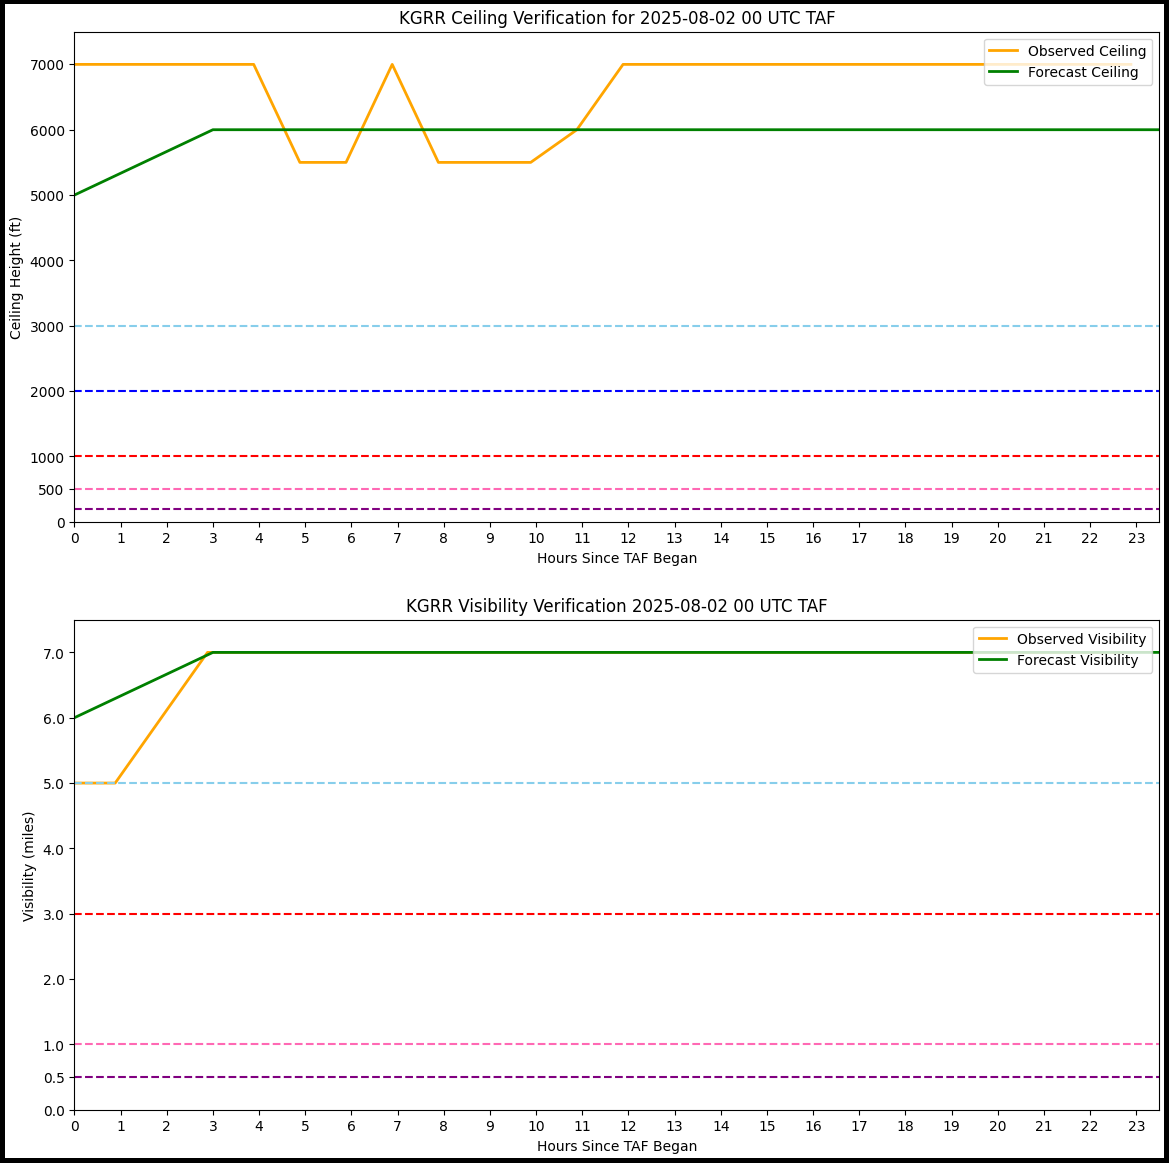

In [493]:
fig = plt.figure(figsize=(14, 14), facecolor='white', edgecolor="black", linewidth =6)

ax1 = plt.subplot(2,1,1)
ax1.set_title(f'{airport} Ceiling Verification for {year}-{month}-{day} {hour} UTC TAF')
cigline = ax1.plot(df['hour'], df['adj_cigs'], color = 'orange', label = 'Observed Ceiling', linewidth = 2)
fcstcig = ax1.plot(fmgroup['hour'], fmgroup['cigs'], color = 'green', label = 'Forecast Ceiling', linewidth = 2)

ax1.set_ylim(0,7500)
ax1.set_ylabel('Ceiling Height (ft)')
ax1.set_yticks([0,500,1000,2000,3000,4000,5000,6000,7000])
ax1.set_xlabel('Hours Since TAF Began')
ax1.axhline(y=3000, color='skyblue', linestyle='--')
ax1.axhline(y=2000, color='blue', linestyle='--')
ax1.axhline(y=1000, color='red', linestyle='--')
ax1.axhline(y=500, color='hotpink', linestyle='--')
ax1.axhline(y=200, color='purple', linestyle='--')
ax1.legend(loc = 'upper right')
ax1.set_xlim(0,23.5)
ax1.set_xticks(np.arange(0,23.5,1))

ax2 = plt.subplot(2,1,2)
ax2.set_title(f'{airport} Visibility Verification {year}-{month}-{day} {hour} UTC TAF')
visline = ax2.plot(df['hour'], df['adj_visby'], color = 'orange', label = 'Observed Visibility', linewidth = 2)
fcstvis = ax2.plot(fmgroup['hour'], fmgroup['visby'], color = 'green', label = 'Forecast Visibility', linewidth = 2)
ax2.legend(loc = 'upper right')
ax2.set_xlabel('Hours Since TAF Began')
ax2.set_ylabel('Visibility (miles)')
ax2.set_ylim(0,7.5)
ax2.set_yticks([0,0.5,1,2,3,4,5,6,7])
ax2.axhline(y=5, color='skyblue', linestyle='--')
ax2.axhline(y=3, color='red', linestyle='--')
ax2.axhline(y=1, color='hotpink', linestyle='--')
ax2.axhline(y=0.5, color='purple', linestyle='--')
ax2.set_xlim(0,23.5)
ax2.set_xticks(np.arange(0,23.5,1))

plt.show()
